# Preparing for an Audience

## Generating some sample data

### Definitions

__octet__ is a non-negative integer below 256

Four __octets__ form an IP address, e.g. 194.82.329.12

IP addresses beginning 192.168.0 are normally internal to a network. Most others are external (i.e. are users or machines on the internet)

### Sample Script for Creating Fake Data

We will pass by this for the moment, but you may wish to use some time to see what functions exist in `numpy` and `random` modules for generating randomized data - some of the exercises in the comments may help.

In [11]:
import pandas as pd
import numpy as np
import random

requests = pd.DataFrame(columns=['IP', 'Verb', 'Processing Time', 'Memory'])

# Settings
SPAM_IPS = 5
EXTERNAL_IPS = 100
SAMPLE_DATA_LENGTH = 1200

# *** Comment about np.random.choice (what it gives as output, what the parameters are)

# np.random.choice randomly selects values from the provided list ['GET', 'POST', 'PUT']
# The first parameter is the list of possible values to choose from
# The second parameter is the number of random choices to generate, SAMPLE_DATA_LENGTH in this case

requests['Verb'] = np.random.choice(['GET', 'POST', 'PUT'], SAMPLE_DATA_LENGTH)
requests['Processing Time'] = np.random.normal(200, scale=20, size=SAMPLE_DATA_LENGTH)

# *** What does this do to the Processing Time for all the rows that have Verb==POST?
## Generate random processing times with a normal distribution (mean=200, std_dev=20)
requests.loc[requests['Verb'] == 'POST', 'Processing Time'] *= 1.2
requests['Memory'] = np.random.normal(30, scale=5, size=SAMPLE_DATA_LENGTH)

# *** Comment about how IP addresses are built up (fill in the ???)
# np.random.randint returns an array of shape (EXTERNAL_IPS, 4)
# these are cast to strings by .astype(str)

#np.random.randint generates a 2D array with EXTERNAL_IPS rows and 4 columns, where
#each element represents an octet of the IP address. These integers are then converted to strings using .astype(str)
octet_array = np.random.randint(1, 256, size=(EXTERNAL_IPS, 4)).astype(str)

# map then applies '.'.join to each row
external_ips = list(map('.'.join, octet_array))

# Here we create an exponential distribution - several "spam" IPs are made much more frequent than other IPs
external_ip_distribution = np.random.exponential(scale=1, size=EXTERNAL_IPS)
external_ip_distribution[:SPAM_IPS] *= 100
external_ip_distribution /= sum(external_ip_distribution)

# *** What does the p term do?
# The p parameter specifies the probabilities associated with each entry in external_ips
requests['IP'] = np.random.choice(external_ips, SAMPLE_DATA_LENGTH, p=external_ip_distribution)

# Create a function for working out an IP range
# (i.e. turning '192.123.3.1' into '192', '192.123' or '192.123.3' if the first argument is 1, 2 or 3 respectively)
ip_to_range = lambda octets, address: '.'.join(address.split('.')[:octets])

# We pluck 3 IP addresses, and use them to choose 3 ranges - IPs in these ranges then have their processing times scaled up
adjusted_ranges = {ip_to_range(i + 1, s): np.random.random() * 10 for i, s in enumerate(requests['IP'].sample(3))}
for range_prefix, factor in adjusted_ranges.items():
    requests.loc[requests['IP'].str.startswith(range_prefix), 'Processing Time'] *= factor

# We pick a two-thirds (how?) of IPs to be local IPs and overwrite their addresses with IPs in the 192.168.0.xxx range
# Assign local IPs to two-thirds of the requests
# np.random.choice([True, True, False], SAMPLE_DATA_LENGTH) creates a boolean mask
# It randomly selects True or False, with True being twice as likely
local_ips = np.random.choice([True, True, False], SAMPLE_DATA_LENGTH)
local_ip_count = requests.loc[local_ips, 'IP'].count()
requests.loc[local_ips, 'IP'] = list(map(lambda s: '192.168.0.%d' % s, np.random.randint(1, 256, size=local_ip_count)))

requests

,IP,Verb,Processing Time,Memory
0,192.168.0.214,PUT,5424.205546,25.924797
1,192.168.0.74,POST,6684.740229,30.093501
2,192.168.0.40,PUT,237.306609,28.664472
3,192.168.0.21,GET,4613.275334,25.863241
4,192.168.0.114,GET,5858.743466,29.755111
...,...,...,...,...
1195,192.168.0.65,PUT,1511.793301,24.150379
1196,192.168.0.31,GET,224.786248,25.726011
1197,39.101.61.100,PUT,221.290813,37.846102
1198,223.255.163.71,GET,1044.688437,24.337959


## Viewing for our use

<Axes: xlabel='IP'>

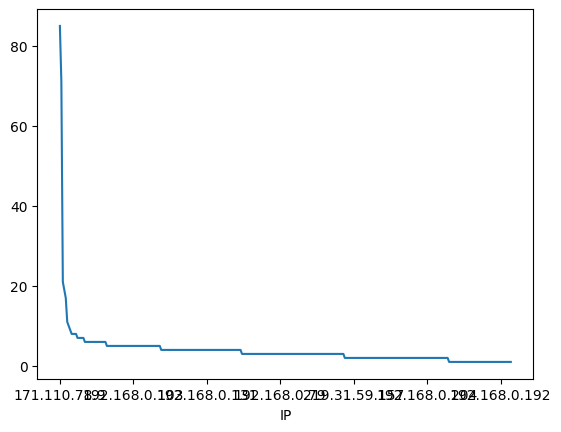

In [2]:
%matplotlib inline
requests.groupby('IP')['Verb'].count().sort_values(ascending=False).plot()

We can see from this that there are a few IPs hitting our service over 12 times, and at least 1 over 100 (may be slightly different for your randomized data)

This sounds a lot like some form of spamming going on, or possibly exploit scanning of some sort. The more general red flag is that the profile of the other traffic, presumably mostly normal users, is very different (under 10 requests per address).

Verb
GET     Axes(0.125,0.11;0.775x0.77)
POST    Axes(0.125,0.11;0.775x0.77)
PUT     Axes(0.125,0.11;0.775x0.77)
dtype: object

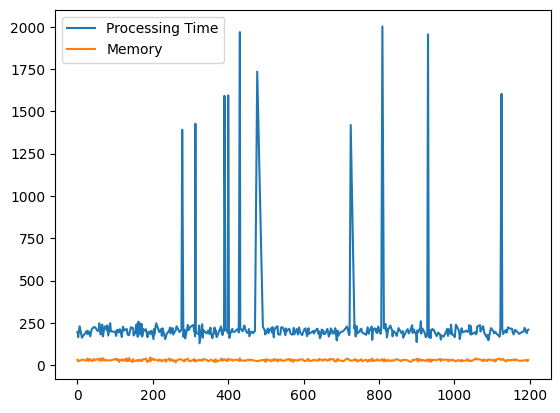

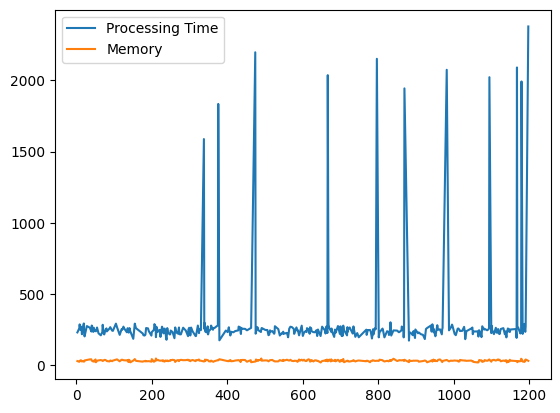

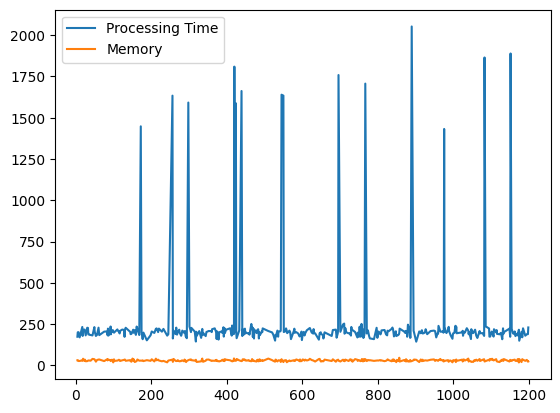

In [3]:
requests.groupby('Verb').plot()

Again, these are a series of quick and dirty plots to give us some basic information. We can see that the processing time for the POST verb is somewhat higher. This may or may not be unexpected, depending on our service.

## First Flush

In previous sessions, we learned how to tidy up a plot somewhat. This is an example for the first one:

<Axes: title={'center': 'Requests per IP Address'}, xlabel='IP Address', ylabel='# of Requests'>

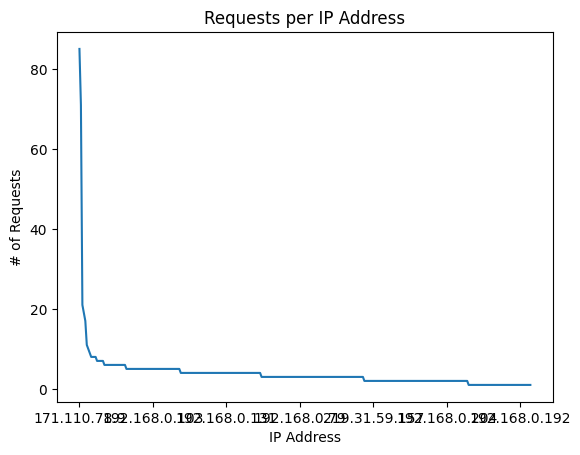

In [4]:
requests_per_ip = requests.groupby('IP')['Verb'].count()

ax = requests_per_ip.sort_values(ascending=False).plot()
ax.set_title('Requests per IP Address')
ax.set_ylabel('# of Requests')
ax.set_xlabel('IP Address')
ax

Now, that's great, but it doesn't really tell any given story fully... What could we possibly want to know from the plotted data? For example:
* how many IP addresses have vastly more requests than others
* what fraction of our users are only touching the service once or twice
* what the mean or modal number of hits is for a user

If we saw that plot in an article, would we feel satisfied we understood the answers to any of those? Maybe not...

## A recipe for clear communication

Science communication is not just a skillset, it's an expert research area in its own right. However, it's important precisely because research is only as useful as its reporting allows, so _all_ scientists need to be aware of key scientific communication concepts. Not only is it critical to impact, but good scientific communication increases citation rates and professional profile.

That means reader-friendly reporting has to be achievable without requiring lots of time or graphics talents. To help researchers get the basics down, there are a number of checklist-based approaches to making plots useful.

One is from [Boris Gorelik](https://gorelik.net/), a data visualization expert at Automattic, the company behind Wordpress. It is the a series of steps called [ABCD](https://github.com/bgbg/datascience_dataviz_workshop/blob/8c01f70bb4ce42607718c6aa4a32458647649b24/demos/show-relationship/show_relationship.ipynb):
* Audience
  * Who is this specific plot targeted at? What do they want to know? What understanding do you know they have?
* Build the graph
  * Code up the first version for that audience
* Conclusion
  * Why are you making this graph? How can you ensure that is clear?
* Delete
  * What is redundant? How much [non-data-ink](https://infovis-wiki.net/wiki/Data-Ink_Ratio) can you remove? (see below)

Think through each one carefully in turn to decide how you should approach it.

### Exercise

Find one (not too complex) plot you like online - how far can you get in 20min trying to make fake data for it in Python (tip: don't worry about getting the data right!)

### Who?

Suppose we are seeking to demonstrate usage patterns of real users - in fact, this works either for a Business Intelligence presentation in industry, or a usage patterns survey in an academic journal.

Our target audience is:
* subject-matter experts
* who may not be technical (certainly in networks)
* who have virtually no time to spend looking at this plot

They want to know:
* how many users heavily use the system
* how many users lightly use the system

What they don't care about:
* anything more than headline detail on spammers

### How?

First off, for this audience, we want don't care _that_ much about spammers. How can we turn the data from being dominated by a few users to clearly showing general usage patterns?

We could eliminate outliers - but then we have to think carefully about how that changes the message (for example, our highest usage real users suddenly look like they dominate our resource consumption). Many of these frequency metrics follow a normal distribution or otherwise exponential-based patterns - perhaps we should try a log graph?

<Axes: title={'center': 'Requests per IP Address'}, xlabel='IP Address', ylabel='# of Requests'>

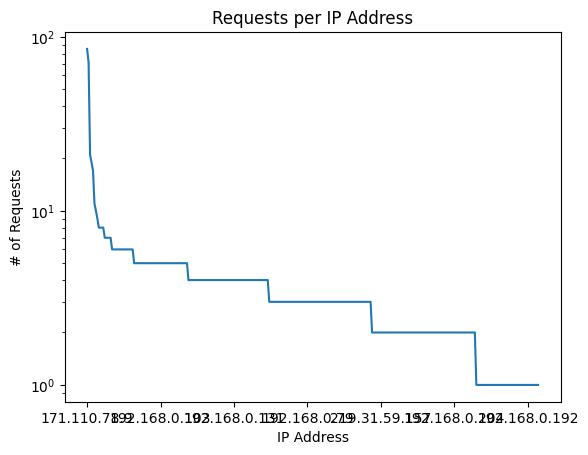

In [5]:
ax = requests_per_ip.sort_values(ascending=False).plot(logy=True)
ax.set_title('Requests per IP Address')
ax.set_ylabel('# of Requests')
ax.set_xlabel('IP Address')
ax

That's better. We can now see clearly the variation between the bulk of users. About half use the service at most 3 times, virtually all less than 10. However, we're having to guess lengths of segments by eye.

If only there was a common way of showing frequencies of values...

In [6]:
frequencies_of_request_count = requests_per_ip.value_counts().sort_index()
# Number of requests | How many IP addresses made that number of requests
# e.g. 1      62
#     means 62 IPs made only 1 request
frequencies_of_request_count

Verb
1     43
2     71
3     70
4     55
5     37
6     15
7      5
8      4
9      1
10     1
11     1
17     1
19     1
21     1
71     1
85     1
Name: count, dtype: int64

Text(0.5, 0, 'Total Requests from an IP')

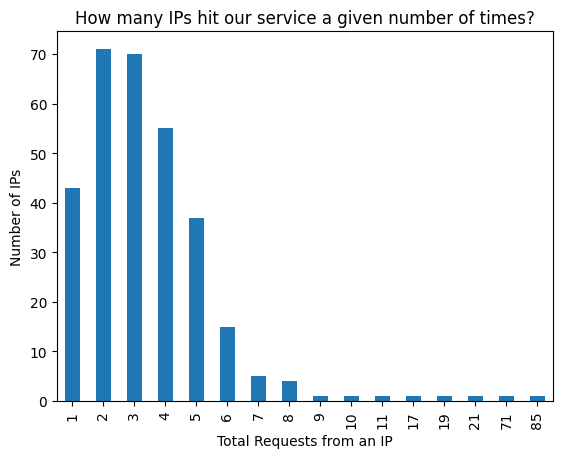

In [7]:
ax = frequencies_of_request_count.plot.bar()
ax.set_title("How many IPs hit our service a given number of times?")
ax.set_ylabel("Number of IPs")
ax.set_xlabel("Total Requests from an IP")

That shows our low-frequency data fairly clearly, but the linear scale at the bottom suddenly jumping about seems counterintuitive and confusing. There are also a lot of Perhaps groupings would be more helpful.

In [8]:
# Set up our ranges
request_counts = [("1", (1, 2)), ("2", (2, 3)), ("3-5", (3, 6)), ("6-8", (6, 9)), ("9-11", (9, 12)), ("12 or more", (12, None))]

# We could do this manually... this helps us understand the data
request_count_df = pd.DataFrame(columns=("Frequency",), index=[r[0] for r in request_counts])

for label, (lower, upper) in request_counts:
    request_count_df["Frequency"][label] = frequencies_of_request_count.loc[lower:upper].sum()

request_count_df

,Frequency
1,114
2,141
3-5,177
6-8,25
9-11,3
12 or more,5


<Axes: ylabel='Frequency'>

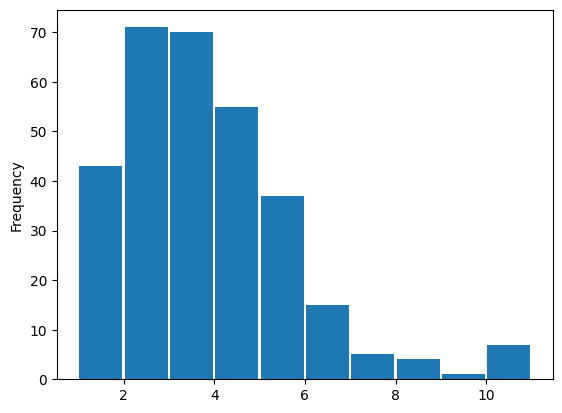

In [9]:
# But we can also use the histogram plot

# Cap the upper end so we don't extend x out to the 100s
capped_requests_per_ip = requests_per_ip.copy()
capped_requests_per_ip[capped_requests_per_ip > 10] = 10
ax = capped_requests_per_ip.plot.hist(bins=range(1, 12), rwidth=0.95)
ax

This is more approachable for a nontechnical user, and shows more clearly the spread of how regular users use the system. But we can tidy this up now.

<Axes: title={'center': 'How many IPs hit our service a given number of times?'}, xlabel='Total Requests from an IP', ylabel='Number of IPs'>

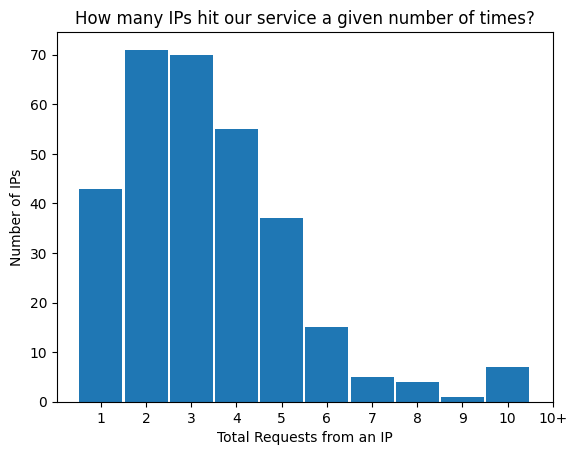

In [12]:
bins = range(1, 12)
ax = capped_requests_per_ip.plot.hist(bins=bins, rwidth=0.95)
bar_width = 1
ax.set_xticks(np.array(bins) + bar_width / 2)
ax.set_xticklabels((1, 2, 3, 4, 5, 6, 7, 8, 9, 10,"10+"))

ax.set_title("How many IPs hit our service a given number of times?")
ax.set_ylabel("Number of IPs")
ax.set_xlabel("Total Requests from an IP")
ax

### Exercise

Take your previous favourite plot and try to now plot some of your fake data in a similar way to it!

### Why?

What are we trying to show here? Depending on your context, you may need to take care not to prejudice the reader toward your conclusion - if you have the freedom to do so, placing the conclusion in the title (e.g. "Many users do not return") can help a reader immediately understand the point you wish to make with the plot. In academic publishing though, it is better to go for a clear, unbiased title - a question can help indicate what you are seeking to demonstrate.

If your audience is likely to be speed reading, this is especially helpful.

We also talk about IPs, while we seek to understand users. Again, audience is important: "Total Visits from a User (by IP)" might be preferred in industry - in academia, it may be better to caption the x-axis as "Total Requests from an IP" and explain it as a proxy for users in the text.

We can highlight the features of the graph that let readers draw their own conclusions. Again, be careful if writing for academia not to do so in a way that artificially prejudices them to your interpretation.

<Axes: title={'center': 'How many IPs hit our service a given number of times?'}, xlabel='Total Requests from an IP (single visits in red-hatch)', ylabel='Number of IPs'>

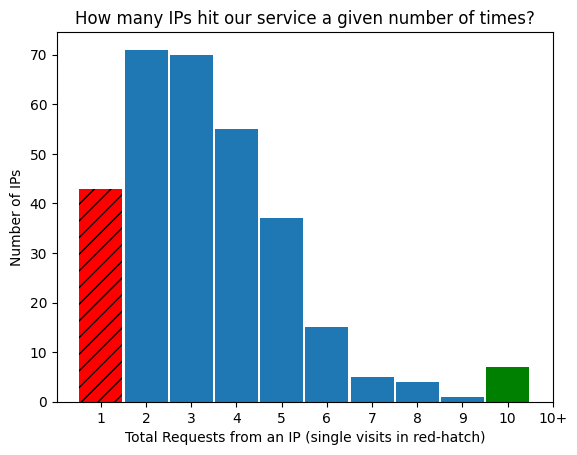

In [15]:
import matplotlib.pyplot as plt

bins = range(1, 12)

# Switch to using matplotlib directly, to get more control
ax = plt.axes()
N, bins, patches = plt.hist(capped_requests_per_ip, bins=bins, rwidth=0.95)
patches[0].set_facecolor('red')
patches[0].set_hatch('//')
# We can highlight the final bar to draw the reader's attention to the fact it is different
patches[-1].set_facecolor('green')

bar_width = 1
ax.set_xticks(np.array(bins) + bar_width / 2)
ax.set_xticklabels((1, 2, 3, 4, 5, 6, 7, 8, 9, 10,"10+"))

ax.set_title("How many IPs hit our service a given number of times?")
ax.set_ylabel("Number of IPs")
ax.set_xlabel("Total Requests from an IP (single visits in red-hatch)")
ax

Now to help make our conclusions clear, we can highlight the key text and draw attention to our underlying question.

<Axes: title={'center': 'How many user IPs appear\n a given number of times?'}, xlabel='Total Requests from an IP (single visits in red-hatch)', ylabel='Number of IPs'>

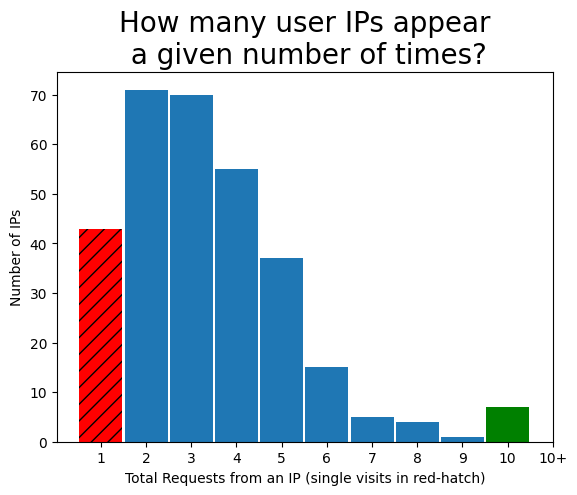

In [16]:
import matplotlib.pyplot as plt

bins = range(1, 12)

# Switch to using matplotlib directly, to get more control
ax = plt.axes()
N, bins, patches = plt.hist(capped_requests_per_ip, bins=bins, rwidth=0.95)
patches[0].set_facecolor('red')
patches[0].set_hatch('//')
# We can highlight the final bar to draw the reader's attention to the fact it is different
patches[-1].set_facecolor('green')

bar_width = 1
ax.set_xticks(np.array(bins) + bar_width / 2)
ax.set_xticklabels((1, 2, 3, 4, 5, 6, 7, 8, 9, 10,"10+"))

ax.set_title("How many user IPs appear\n a given number of times?")
ax.title.set_fontsize(20)
ax.set_ylabel("Number of IPs")
ax.set_xlabel("Total Requests from an IP (single visits in red-hatch)")
ax

If our primary conclusion was that users drop off gradually as we move up the request count, we may be more interested in a regression to show the gradual curve:

[-3.94302984 91.0626296  -0.20066113]


<Axes: title={'center': 'How often does each user IP\nuse our service?'}, xlabel='Total Requests from an IP (orange curve: fitted $a e^{b x}+c$)', ylabel='Number of IPs'>

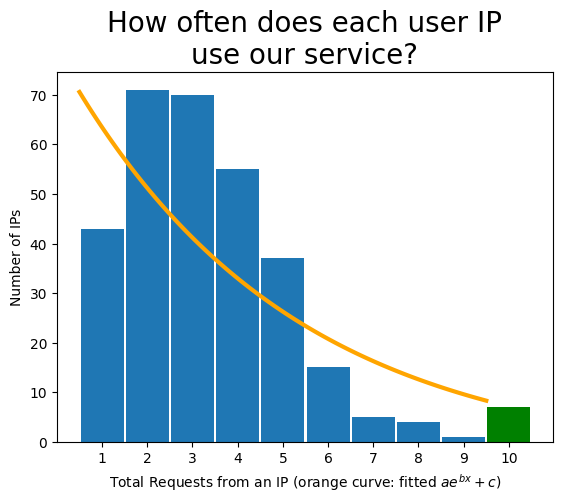

In [19]:
import scipy.optimize
import matplotlib.pyplot as plt

bins = range(1, 12)

# Switch to using matplotlib directly, to get more control
ax = plt.axes()
N, bins, patches = plt.hist(capped_requests_per_ip, bins=bins, rwidth=0.95)
# We can highlight the final bar to draw the reader's attention to the fact it is different
patches[-1].set_facecolor('green')

bar_width = 1
ax.set_xticks(np.array(bins) + bar_width / 2)
ax.set_xticklabels((1, 2, 3, 4, 5, 6, 7, 8, 9, 10,"10+"))

# Get the actual numbers used in the histogram
frequencies_of_request_count = requests_per_ip.value_counts().sort_index()

# We define a curve function with several parameters we wish to fit
def fitted_exp(x, a, b, c):
    return a + b * np.exp(c * x)

# Scipy then fits it for us
params, cov = scipy.optimize.curve_fit(
    fitted_exp,
    frequencies_of_request_count.index,
    frequencies_of_request_count.values,
    p0=(-5, 100, -1)
)

print(params)

# Plot our curve using these parameters
exp_x = np.linspace(1, 10, 100)
exp_curve = fitted_exp(exp_x, *params)

ax.set_title("How often does each user IP\nuse our service?")
ax.title.set_fontsize(20)
ax.set_ylabel("Number of IPs")
ax.set_xlabel("Total Requests from an IP (orange curve: fitted $a e^{b x}+c$)")
plt.plot(exp_x, exp_curve, linewidth=3, color='orange')
ax

### What not?

Perhaps the least intuitive step, but one of the most effective - removing anything extraneous from the plot. This means users are not distracted from the relevant results themselves.

Lets suppose we take the final plot above - where we wish to see the drop-off. Perhaps it would be less "fussy" to pair up histogram bins. The audience doesn't care whether an IP visits 7 times or 8 times. (Note that, if our audience was more interested in the single-visit users, as in the red-hatched plot, this wouldn't work). Audience matters.

<Axes: title={'center': 'How often does each user IP\nuse our service?'}, xlabel='Total Requests from an IP\n(orange curve: fitted $a e^{b x}+c$)', ylabel='Number of IPs'>

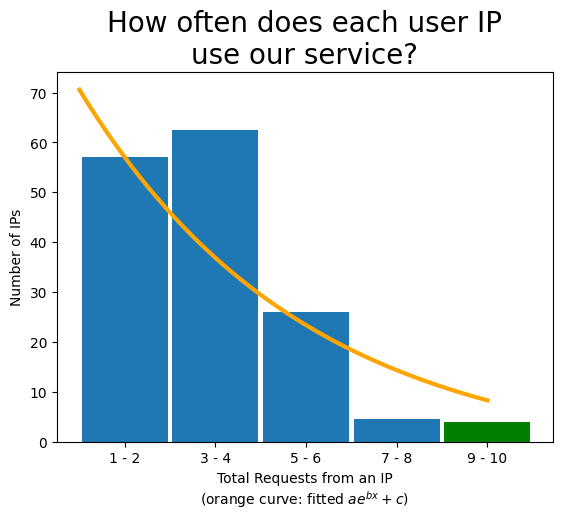

In [24]:
import matplotlib.pyplot as plt

bar_width = 2

bins = range(1, 12, bar_width)

# Switch to using matplotlib directly, to get more control
ax = plt.axes()
rescale_height = np.full(capped_requests_per_ip.shape, 1 / bar_width)
N, bins, patches = plt.hist(capped_requests_per_ip, bins=bins, rwidth=0.95, weights=rescale_height)
# We can highlight the final bar to draw the reader's attention to the fact it is different
patches[-1].set_facecolor('green')

bar_width = 2
ax.set_xticks(np.array(bins) + bar_width / 2)
ax.set_xticklabels(("1 - 2","3 - 4","5 - 6", "7 - 8","9 - 10","10+"))

# Get the actual numbers used in the histogram
frequencies_of_request_count = requests_per_ip.value_counts().sort_index()

# We define a curve function with several parameters we wish to fit
def fitted_exp(x, a, b, c):
    return a + b * np.exp(c * x)

# Scipy then fits it for us
params, cov = scipy.optimize.curve_fit(
    fitted_exp,
    frequencies_of_request_count.index,
    frequencies_of_request_count.values,
    p0=(0, 100, -1)
)

# Plot our curve using these parameters
exp_x = np.linspace(1, 10, 100)
exp_curve = fitted_exp(exp_x, *params)

ax.set_title("How often does each user IP\nuse our service?")
ax.title.set_fontsize(20)
ax.set_ylabel("Number of IPs")
ax.set_xlabel("Total Requests from an IP\n(orange curve: fitted $a e^{b x}+c$)")
plt.plot(exp_x, exp_curve, linewidth=3, color='orange')
ax

The concept of a data-ink ratio - the ratio of ink used to convey relevant information to the total inked space - came from [Edward Tufte](https://en.wikipedia.org/wiki/Edward_Tufte), a data visualization pioneer. He argued it should be maximized by not wasting ink on anything not helping the viewer's understanding.

## Privacy & GDPR

Over the last few years, the law has got much stricter on handling of data. As this is a coding course, I'm not going to touch on it much here, but when preparing data for sharing it's critical to think this through.

In this case, we use IP addresses - at least some could be used to identify an individual (obviously, we have used fake ones for this exercise, but normally they would be real). This means we have to be legally _extremely_ careful with how we handle them.

This goes hand-in-hand with the push for reproducible science. There is a strong push across academia to get your results in the public, so they can be examined by other scientists, randomers, companies without your oversight -- this is partially a result of scientists discovering that a large amount of literature was unreproducible and, therefore, effectively useless (and, moreover, dangerous, especially in engineering and life sciences).

How can you release data that involves personal information (or IPs, MAC addresses, etc.)? One idea is to group it.

In [25]:
capped_requests_per_ip.head()

IP
107.7.219.185      1
111.147.56.203     4
119.151.249.209    1
12.114.38.194      4
120.43.76.126      3
Name: Verb, dtype: int64

Lets group this in IP blocks of the last octet, i.e. `11.222.33.4` and `11.222.33.91` become part of the same `11.222.33.xxx` entry.

In [26]:
# IP to head
octets = 3

def aggregate_ip(ip):
    if ip.startswith('192.168'):
        # This is local, we keep it if we are confident this isn't personally-identifiable information
        return ip
    else:
        # This function from the very start truncates an IP address
        return ip_to_range(octets, ip)

agg_requests_per_ip = pd.DataFrame({'IP': requests_per_ip.values})
agg_requests_per_ip['Group'] = list(map(lambda ip: aggregate_ip(ip), requests_per_ip.index))
agg_requests_per_ip.head()

,IP,Group
0,1,107.7.219
1,4,111.147.56
2,1,119.151.249
3,4,12.114.38
4,3,120.43.76


In [27]:
agg_requests_per_ip['Count'] = 1
agg_requests_per_ip = agg_requests_per_ip.groupby('Group').agg('sum')
agg_requests_per_ip.head()

,IP,Count
Group,,
107.7.219,1,1
111.147.56,4,1
119.151.249,1,1
12.114.38,4,1
120.43.76,3,1


<Axes: title={'center': 'How often does each user IP\nuse our service?'}, xlabel='Total Requests from an IP\n(external IPs grouped by octet 3)', ylabel='Number of IPs'>

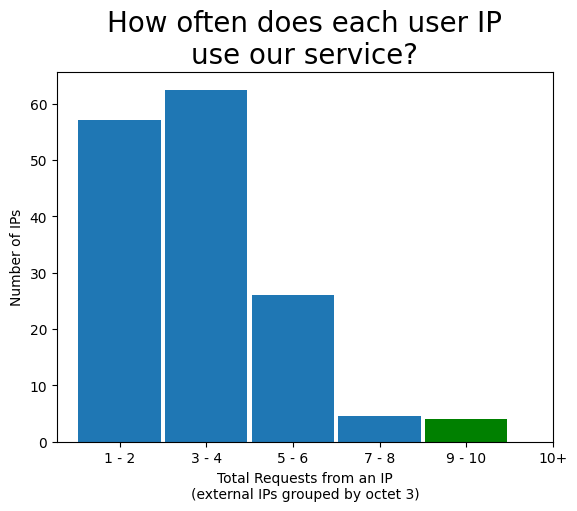

In [29]:
import matplotlib.pyplot as plt

bar_width = 2

bins = range(1, 12, bar_width)
capped_agg_requests_per_ip = agg_requests_per_ip.copy()
capped_agg_requests_per_ip[capped_agg_requests_per_ip > 9] = 9

# Switch to using matplotlib directly, to get more control
ax = plt.axes()
rescale_height = np.full(capped_agg_requests_per_ip['IP'].shape, 1 / bar_width)
N, bins, patches = plt.hist(capped_agg_requests_per_ip['IP'], bins=bins, rwidth=0.95, weights=rescale_height)
# We can highlight the final bar to draw the reader's attention to the fact it is different
patches[-1].set_facecolor('green')

bar_width = 2
ax.set_xticks(np.array(bins) + bar_width / 2)
ax.set_xticklabels(("1 - 2","3 - 4","5 - 6", "7 - 8","9 - 10","10+"))

ax.set_title("How often does each user IP\nuse our service?")
ax.title.set_fontsize(20)
ax.set_ylabel("Number of IPs")
ax.set_xlabel("Total Requests from an IP\n(external IPs grouped by octet %d)" % octets)
ax

### Exercise

Experiment with changing the octet count - using the whole IP `1.2.3.4` (octets=4), grouping a bit `1.2.3.x` (octets=3), grouping more `1.2.x.x` (octets=2) and grouping right at the top `1.x.x.x` (octets=1). Does it materially change your output plot?

<ipython-input-32-ba90658cb7fe>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capped_requests_per_ip['requests'][capped_requests_per_ip['requests'] > 9] = 9


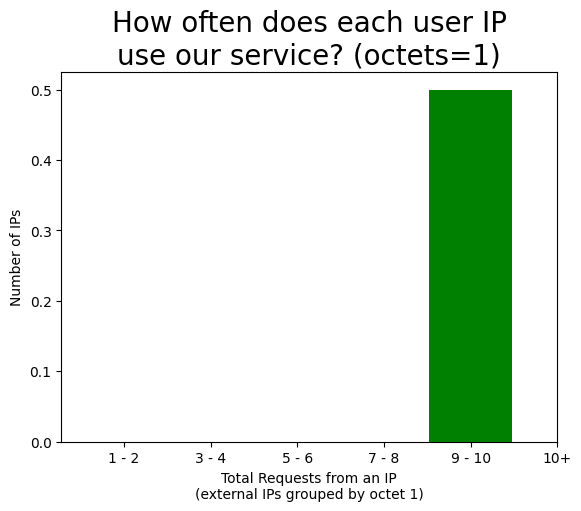

<ipython-input-32-ba90658cb7fe>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capped_requests_per_ip['requests'][capped_requests_per_ip['requests'] > 9] = 9


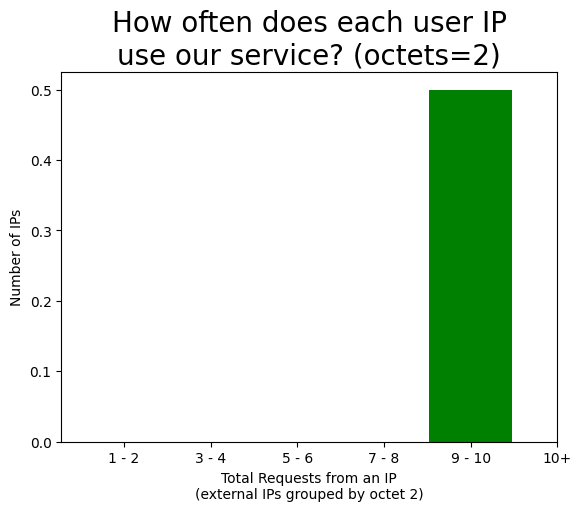

<ipython-input-32-ba90658cb7fe>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capped_requests_per_ip['requests'][capped_requests_per_ip['requests'] > 9] = 9


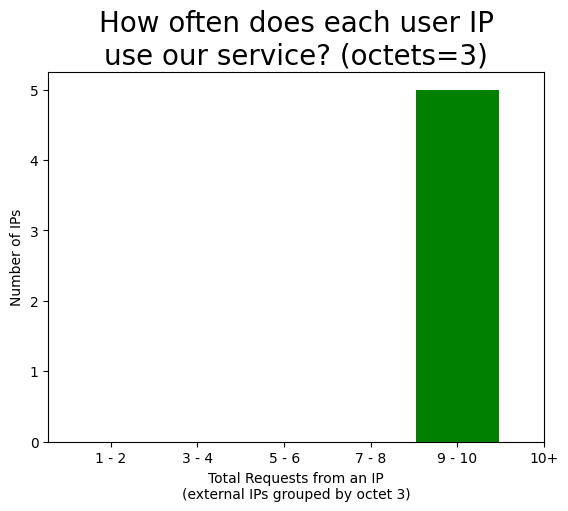

<ipython-input-32-ba90658cb7fe>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capped_requests_per_ip['requests'][capped_requests_per_ip['requests'] > 9] = 9


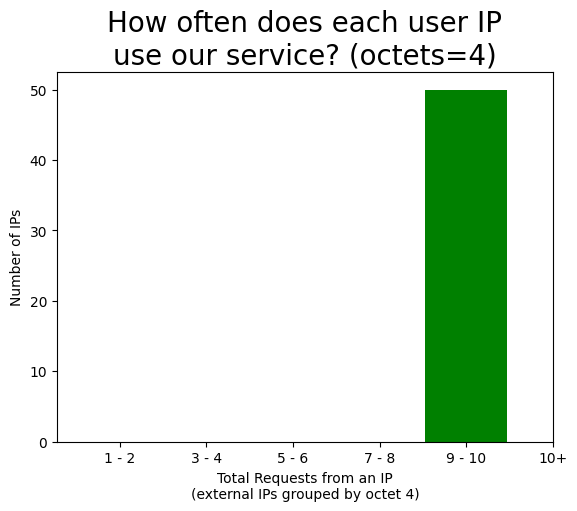

In [32]:

np.random.seed(0)  # For reproducibility
agg_requests_per_ip = pd.DataFrame({
    'IP': np.random.choice([f'192.168.{i}.{j}' for i in range(10) for j in range(10)], 1000)
})
agg_requests_per_ip['requests'] = np.random.poisson(5, size=1000)


# Function to change IP grouping by octets
def group_ips_by_octets(agg_requests_per_ip, octets):
    agg_requests_per_ip['grouped_ip'] = agg_requests_per_ip['IP'].apply(lambda ip: '.'.join(ip.split('.')[:octets]))
    return agg_requests_per_ip.groupby('grouped_ip')['requests'].sum().reset_index()

# Plotting function
def plot_requests_distribution(grouped_data, octets):
    bar_width = 2
    bins = range(1, 12, bar_width)
    capped_requests_per_ip = grouped_data.copy()
    capped_requests_per_ip['requests'][capped_requests_per_ip['requests'] > 9] = 9

    ax = plt.axes()
    rescale_height = np.full(capped_requests_per_ip['requests'].shape, 1 / bar_width)
    N, bins, patches = plt.hist(capped_requests_per_ip['requests'], bins=bins, rwidth=0.95, weights=rescale_height)

    patches[-1].set_facecolor('green')

    ax.set_xticks(np.array(bins) + bar_width / 2)
    ax.set_xticklabels(["1 - 2", "3 - 4", "5 - 6", "7 - 8", "9 - 10", "10+"])

    ax.set_title(f"How often does each user IP\nuse our service? (octets={octets})")
    ax.title.set_fontsize(20)
    ax.set_ylabel("Number of IPs")
    ax.set_xlabel(f"Total Requests from an IP\n(external IPs grouped by octet {octets})")
    plt.show()

# Testing different octet groupings
for octets in range(1, 5):
    grouped_data = group_ips_by_octets(agg_requests_per_ip, octets)
    plot_requests_distribution(grouped_data, octets)


Now see what impact removing the if clause that _keeps_ local IPs - so they get aggregated too. Does this make a difference for 2 octet aggregation or 3 octet aggregation?

Could you do all your analysis using the 2 octets (which have a low risk of violating users' privacy) rather than the full IP addresses, and release that data to a public journal?

<ipython-input-33-307d52368c8e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capped_requests_per_ip['requests'][capped_requests_per_ip['requests'] > 9] = 9


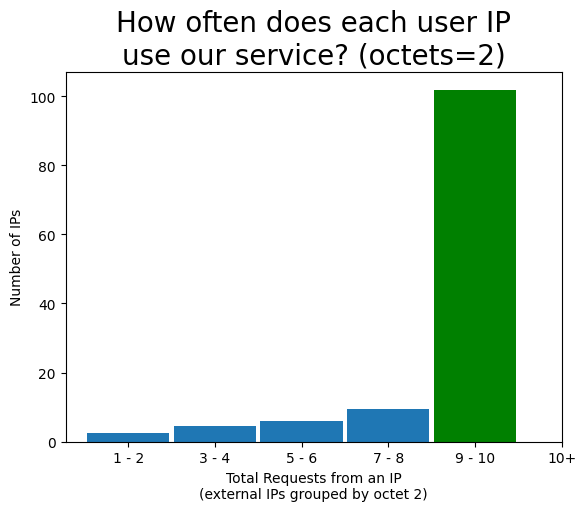

<ipython-input-33-307d52368c8e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capped_requests_per_ip['requests'][capped_requests_per_ip['requests'] > 9] = 9


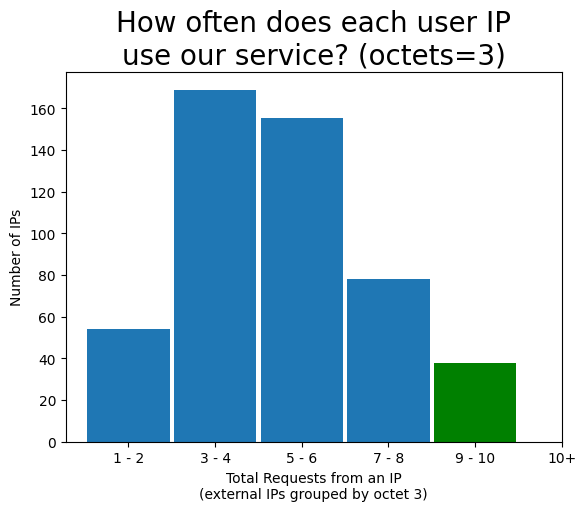

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

# Example data generation
np.random.seed(0)  # For reproducibility
agg_requests_per_ip = pd.DataFrame({
    'IP': np.random.choice([f'192.168.{i}.{j}' for i in range(10) for j in range(10)] +
                           [f'10.{i}.{j}.{k}' for i in range(1, 256) for j in range(1, 256) for k in range(1, 256)],
                           1000)
})
agg_requests_per_ip['requests'] = np.random.poisson(5, size=1000)

# Function to change IP grouping by octets
def group_ips_by_octets(agg_requests_per_ip, octets):
    agg_requests_per_ip['grouped_ip'] = agg_requests_per_ip['IP'].apply(lambda ip: '.'.join(ip.split('.')[:octets]))
    return agg_requests_per_ip.groupby('grouped_ip')['requests'].sum().reset_index()

# Plotting function
def plot_requests_distribution(grouped_data, octets):
    bar_width = 2
    bins = range(1, 12, bar_width)
    capped_requests_per_ip = grouped_data.copy()
    capped_requests_per_ip['requests'][capped_requests_per_ip['requests'] > 9] = 9

    ax = plt.axes()
    rescale_height = np.full(capped_requests_per_ip['requests'].shape, 1 / bar_width)
    N, bins, patches = plt.hist(capped_requests_per_ip['requests'], bins=bins, rwidth=0.95, weights=rescale_height)

    patches[-1].set_facecolor('green')

    bar_width = 2
    ax.set_xticks(np.array(bins) + bar_width / 2)
    ax.set_xticklabels(["1 - 2", "3 - 4", "5 - 6", "7 - 8", "9 - 10", "10+"])

    ax.set_title(f"How often does each user IP\nuse our service? (octets={octets})")
    ax.title.set_fontsize(20)
    ax.set_ylabel("Number of IPs")
    ax.set_xlabel(f"Total Requests from an IP\n(external IPs grouped by octet {octets})")
    plt.show()

# Testing different octet groupings
for octets in [2, 3]:
    grouped_data = group_ips_by_octets(agg_requests_per_ip, octets)
    plot_requests_distribution(grouped_data, octets)


For more information about the growing mathematical research field around privacy-preserving analysis, read about [k-anonymity](https://en.wikipedia.org/wiki/K-anonymity).

## Exercise

You are going to present a lightning talk to a technical team lead. They want to understand where in the application they should start looking for issues - you decide to explore the relationship between HTTP verbs used (GET, POST, PUT) and the performance of your service (see the plots above). Follow the steps above using the cells below:

### Who?

As my audience is ... , I should focus on ... and am less interested in ...

### How?

### Why?

I can conclude that ...
The most important parts of the plot to evaluate this conclusion are ... (taking care not to prejudice the viewer)

In [ ]:
# Here is my plot illustrating the key aspects

# ...

### What not?

I can see several lines and/or text that I could get rid of, without changing the meaning of the plot.

In [ ]:
# This is the plot without them

# ...

### Exercise

Try to improve the plot you found that you were working on!

## Next steps

Moving into the world of infographics, you can find excellent scientific communication tutorials such as:

* https://blog.mindthegraph.com/category/tutorials/
* https://blogs.unimelb.edu.au/sciencecommunication/2018/09/25/science-communication-storytelling-with-data/